# Assignment 4

In [ ]:
import os
import math
import argparse
import random
import numpy as np
import pandas
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data
import torchvision.transforms as transforms
import torchvision.utils as vutils
from IPython.display import HTML
from PIL import Image
from sklearn.preprocessing import MinMaxScaler

torch.use_deterministic_algorithms(False)

device = "cuda:0"

manualSeed = 999
random.seed(manualSeed)

torch.manual_seed(manualSeed)

torch.use_deterministic_algorithms(True) # Needed for reproducible results

dataroot = "Data/images"

batch_size = 128

image_size = 64

num_channels = 3

latent_vector_size = 100

generator_feature_map_size = 64

discriminator_feature_map_size = 64

num_epochs = 5

lr = 0.0002

beta1 = 0.5

num_gpus = 1


In [3]:
def create_dataset(dataset, lookback):
    """Transform a time series into a prediction dataset
    
    Args:
        dataset: A numpy array of time series, first dimension is the time steps
        lookback: Size of window for prediction
    """
    X, y = [], []

    for i in range(len(dataset)-lookback):
        feature = dataset[i:i+lookback]
        X.append(feature)
        
        target = dataset[i+1:i+lookback+1]
        y.append(target)
        
    return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)


# custom weights initialization called on ``netG`` and ``netD``
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)


In [43]:
class CustomDataSet(torch.utils.data.Dataset):
    def __init__(self, main_dir, transform):
        self.main_dir = main_dir
        self.transform = transform
        self.total_imgs = os.listdir(main_dir)

    def __len__(self):
        return len(self.total_imgs)

    def __getitem__(self, idx):
        img_loc = os.path.join(self.main_dir, self.total_imgs[idx])
        image = Image.open(img_loc).convert("RGB")
        tensor_image = self.transform(image)
        
        return tensor_image
    
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(latent_vector_size, generator_feature_map_size * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(generator_feature_map_size * 8),
            nn.ReLU(True),
            # state size. ``(ngf*8) x 4 x 4``
            nn.ConvTranspose2d(generator_feature_map_size * 8, generator_feature_map_size * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(generator_feature_map_size * 4),
            nn.ReLU(True),
            # state size. ``(ngf*4) x 8 x 8``
            nn.ConvTranspose2d( generator_feature_map_size * 4, generator_feature_map_size * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(generator_feature_map_size * 2),
            nn.ReLU(True),
            # state size. ``(ngf*2) x 16 x 16``
            nn.ConvTranspose2d( generator_feature_map_size * 2, generator_feature_map_size, 4, 2, 1, bias=False),
            nn.BatchNorm2d(generator_feature_map_size),
            nn.ReLU(True),
            # state size. ``(ngf) x 32 x 32``
            nn.ConvTranspose2d( generator_feature_map_size, num_channels, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. ``(nc) x 64 x 64``
        )

    def forward(self, input):
        return self.main(input)
    
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is ``(nc) x 64 x 64``
            nn.Conv2d(num_channels, discriminator_feature_map_size, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf) x 32 x 32``
            nn.Conv2d(discriminator_feature_map_size, discriminator_feature_map_size * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(discriminator_feature_map_size * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*2) x 16 x 16``
            nn.Conv2d(discriminator_feature_map_size * 2, discriminator_feature_map_size * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(discriminator_feature_map_size * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*4) x 8 x 8``
            nn.Conv2d(discriminator_feature_map_size * 4, discriminator_feature_map_size * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(discriminator_feature_map_size * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*8) x 4 x 4``
            nn.Conv2d(discriminator_feature_map_size * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)
    
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 8, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(8, 16, 
                               kernel_size=3, 
                               stride=2, 
                               padding=1, 
                               output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, 
                               kernel_size=3, 
                               stride=2, 
                               padding=1, 
                               output_padding=1),
            nn.Sigmoid()
        )
         
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        
        return x
    
class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        pe = pe.permute((1,0,2))
        self.register_buffer('pe', pe)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Arguments:
            x: Tensor, shape ``[batch_size, seq_len, embedding_dim]``
        """
        x = x + self.pe[:x.size(0)]

        return self.dropout(x)
    
class DelhiClimateModel(torch.nn.Module):
    def __init__(self, sequence_length:int, feature_size:int):
        super().__init__()
        
        # dim_feedforward is like width (num of neurons)
        self.linear_projection = torch.nn.Linear(1, feature_size)
        self.positional_encoding = PositionalEncoding(feature_size, max_len=sequence_length)
        self.transformer = torch.nn.Transformer(feature_size, nhead=feature_size, dim_feedforward=feature_size*2, batch_first=True)
        self.relu = torch.nn.ReLU()
        self.fc1 = torch.nn.Linear(feature_size, 1)
    
    def forward(self, source, target):
        x = self.linear_projection(source)
        x = self.positional_encoding(x)
        
        y = self.linear_projection(target)
        y = self.positional_encoding(y)
        result = self.transformer(x, y)

        return self.fc1(self.relu(result))
    

#### Question 1
#### In this question, you will implement and train a Generative Adversarial Network (GAN) to generate realistic anime faces. Use the Anime Face Dataset available at this Kaggle link. Refer to the DCGAN Tutorial on the PyTorch website to guide your implementation. You have to use at least 10k images from the dataset, and you can resize the images down to 64x64 (you can uses more images and bigger size if you want). Produce similar results to the ones shown in the tutorial.

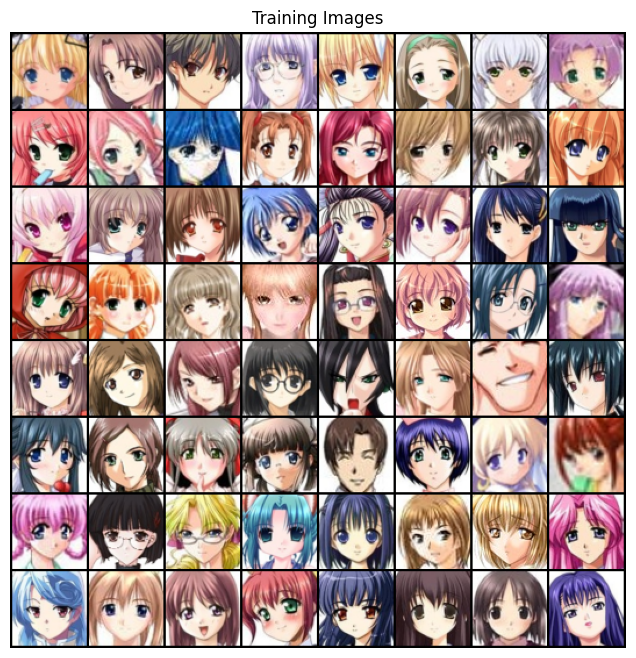

In [4]:
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.CenterCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

img_dataset = CustomDataSet("Data/images", transform)
dataloader = torch.utils.data.DataLoader(img_dataset, batch_size=batch_size, shuffle=True)
real_batch = next(iter(dataloader))

plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[:64].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()


In [5]:
generator = Generator(num_gpus).to(device)

if (device == 'cuda:0') and (num_gpus > 1):
    generator = nn.DataParallel(generator, list(range(num_gpus)))

generator.apply(weights_init)

print(generator)


Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [6]:
discriminator = Discriminator(num_gpus).to(device)

if (device == 'cuda:0') and (num_gpus > 1):
    discriminator = nn.DataParallel(discriminator, list(range(num_gpus)))

discriminator.apply(weights_init)

print(discriminator)


Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [7]:
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, latent_vector_size, 1, 1, device=device)

real_label = 1.
fake_label = 0.

optimizerD = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, 0.999))


In [15]:
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
for epoch in range(num_epochs):
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        data = data.to(device)
        
        discriminator.zero_grad()

        b_size = data.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        
        output = discriminator(data).view(-1)
        errD_real = criterion(output, label)
        errD_real.backward()
        
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, latent_vector_size, 1, 1, device=device)
        fake = generator(noise)
        
        label.fill_(fake_label)

        output = discriminator(fake.detach()).view(-1)
        errD_fake = criterion(output, label)
        errD_fake.backward()
        
        D_G_z1 = output.mean().item()
        
        errD = errD_real + errD_fake
        
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        generator.zero_grad()
        
        label.fill_(real_label)  # fake labels are real for generator cost
        
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = discriminator(fake).view(-1)
        errG = criterion(output, label)
        errG.backward()
        
        D_G_z2 = output.mean().item()

        optimizerG.step()

        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = generator(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1


Starting Training Loop...
[0/5][0/157]	Loss_D: 1.9131	Loss_G: 5.1883	D(x): 0.9975	D(G(z)): 0.8008 / 0.0101
[0/5][50/157]	Loss_D: 4.1306	Loss_G: 23.9695	D(x): 0.9754	D(G(z)): 0.7945 / 0.0000
[0/5][100/157]	Loss_D: 0.6570	Loss_G: 5.5991	D(x): 0.6957	D(G(z)): 0.0485 / 0.0078
[0/5][150/157]	Loss_D: 0.6151	Loss_G: 12.1476	D(x): 0.9574	D(G(z)): 0.3996 / 0.0000
[1/5][0/157]	Loss_D: 1.6036	Loss_G: 11.9746	D(x): 0.4087	D(G(z)): 0.0001 / 0.0000
[1/5][50/157]	Loss_D: 1.0384	Loss_G: 9.1028	D(x): 0.5396	D(G(z)): 0.0022 / 0.0006
[1/5][100/157]	Loss_D: 0.5919	Loss_G: 6.7643	D(x): 0.8785	D(G(z)): 0.2819 / 0.0026
[1/5][150/157]	Loss_D: 0.2926	Loss_G: 6.5463	D(x): 0.8262	D(G(z)): 0.0239 / 0.0051
[2/5][0/157]	Loss_D: 2.3427	Loss_G: 7.3157	D(x): 0.2383	D(G(z)): 0.0005 / 0.0025
[2/5][50/157]	Loss_D: 1.7376	Loss_G: 8.3822	D(x): 0.3369	D(G(z)): 0.0003 / 0.0004
[2/5][100/157]	Loss_D: 0.3131	Loss_G: 4.9596	D(x): 0.8159	D(G(z)): 0.0601 / 0.0120
[2/5][150/157]	Loss_D: 0.2998	Loss_G: 5.4458	D(x): 0.8493	D(G(z)): 

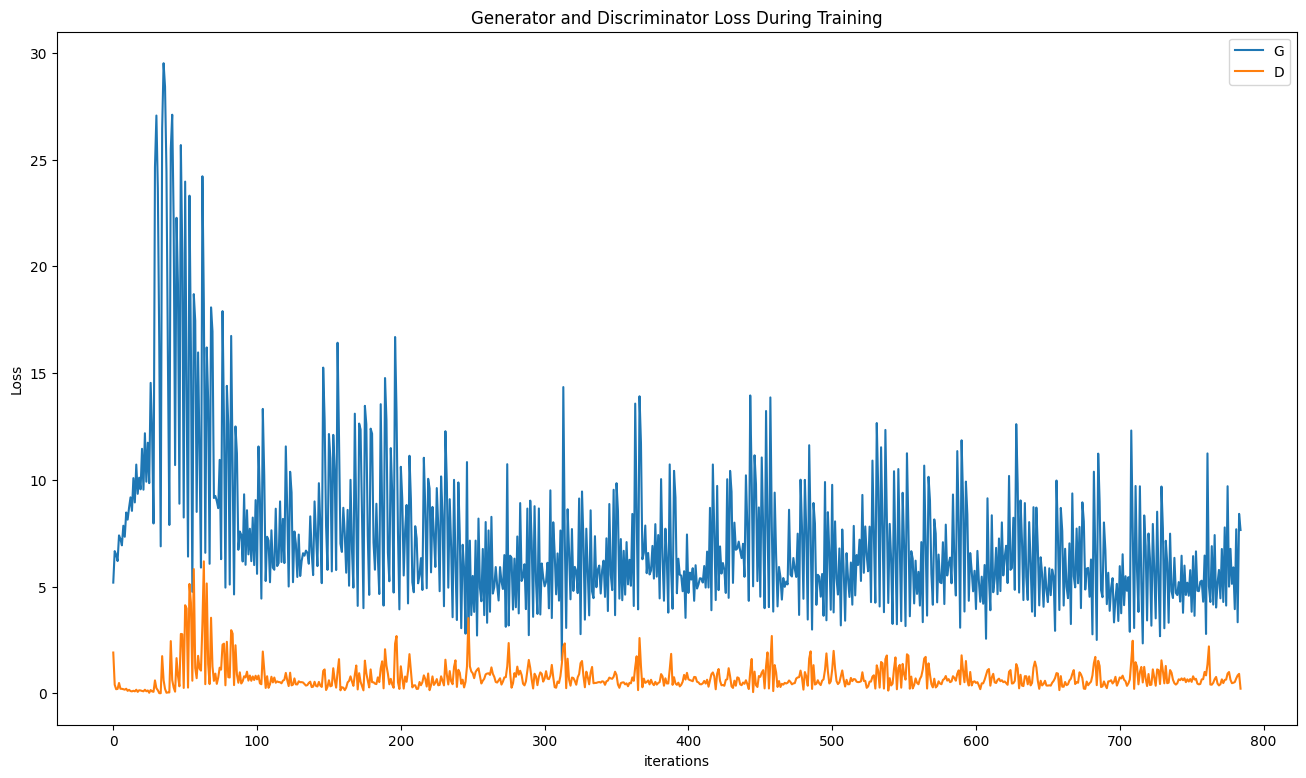

In [16]:
plt.figure(figsize=(16,9))

plt.title("Generator and Discriminator Loss During Training")

plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()

plt.show()


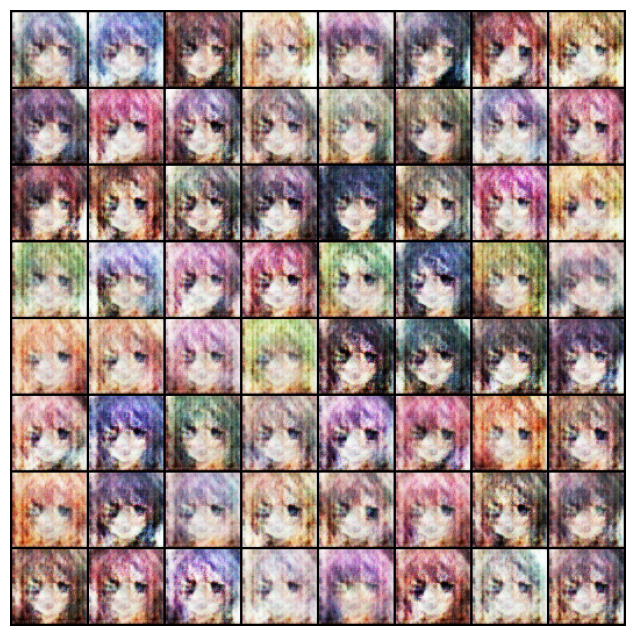

In [17]:
fig = plt.figure(figsize=(8,8))

plt.axis("off")

ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())


#### Question 2
#### In this question, you are tasked with training a Convolutional AutoEncoder (CAE). Again, use the the Anime Face Dataset available at this Kaggle link. You can refer to this tutorial for guidance on how to implement the CAE. You have to use at least 10k images from the dataset, and you can resize the images down to 64x64 (you can uses more images and bigger size if you want). Show results in terms of loss curve as well as comparisons between the original image and its reconstructed version.

In [ ]:
autoencoder = Autoencoder()
autoencoder.to(device)

transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

img_dataset = CustomDataSet("Data/images", transform)
train_set, test_set = torch.utils.data.random_split(img_dataset, [0.7, 0.3], torch.Generator().manual_seed(42))
train_set, val_set = torch.utils.data.random_split(train_set, [0.8, 0.2], torch.Generator().manual_seed(42))
train_loader = torch.utils.data.DataLoader(train_set, 128, True)

val_loader = torch.utils.data.DataLoader(val_set, 128, True)

test_loader = torch.utils.data.DataLoader(test_set, 128)

adam_optimizer = optim.Adam(autoencoder.parameters(), weight_decay=0.001)

num_epochs = 10


In [75]:
all_losses = []

all_val_losses = []

for epoch in range(num_epochs):
    autoencoder.train()

    total_loss = 0.0

    for data in train_loader:
        data = data.to(device)

        adam_optimizer.zero_grad()

        output = autoencoder(data)
        loss = F.mse_loss(output, data)
        loss.backward()

        adam_optimizer.step()

        total_loss += loss.item()

    all_losses.append(total_loss / len(train_loader))

    autoencoder.eval()

    total_val_loss = 0.0

    with torch.no_grad():
        for data in val_loader:
            data = data.to(device)
            output = autoencoder(data)
            loss = F.mse_loss(output, data)
            total_val_loss += loss.item()
    
    all_val_losses.append(total_val_loss / len(val_loader))

    print(f"[COMP433_Assignment_4]: Epoch {epoch + 1} MSE loss (train/validation) = {all_losses[-1]:.4f}/{all_val_losses[-1]:.4f}")

    if len(all_val_losses) >= 2 and (all_val_losses[-1] > all_val_losses[-2] or abs(all_val_losses[-1] - all_val_losses[-2]) < 1e-5):
        break


[COMP433_Assignment_4]: Epoch 1 MSE loss (train/validation) = 0.0637/0.0317
[COMP433_Assignment_4]: Epoch 2 MSE loss (train/validation) = 0.0189/0.0171
[COMP433_Assignment_4]: Epoch 3 MSE loss (train/validation) = 0.0132/0.0142
[COMP433_Assignment_4]: Epoch 4 MSE loss (train/validation) = 0.0115/0.0119
[COMP433_Assignment_4]: Epoch 5 MSE loss (train/validation) = 0.0109/0.0114
[COMP433_Assignment_4]: Epoch 6 MSE loss (train/validation) = 0.0107/0.0116


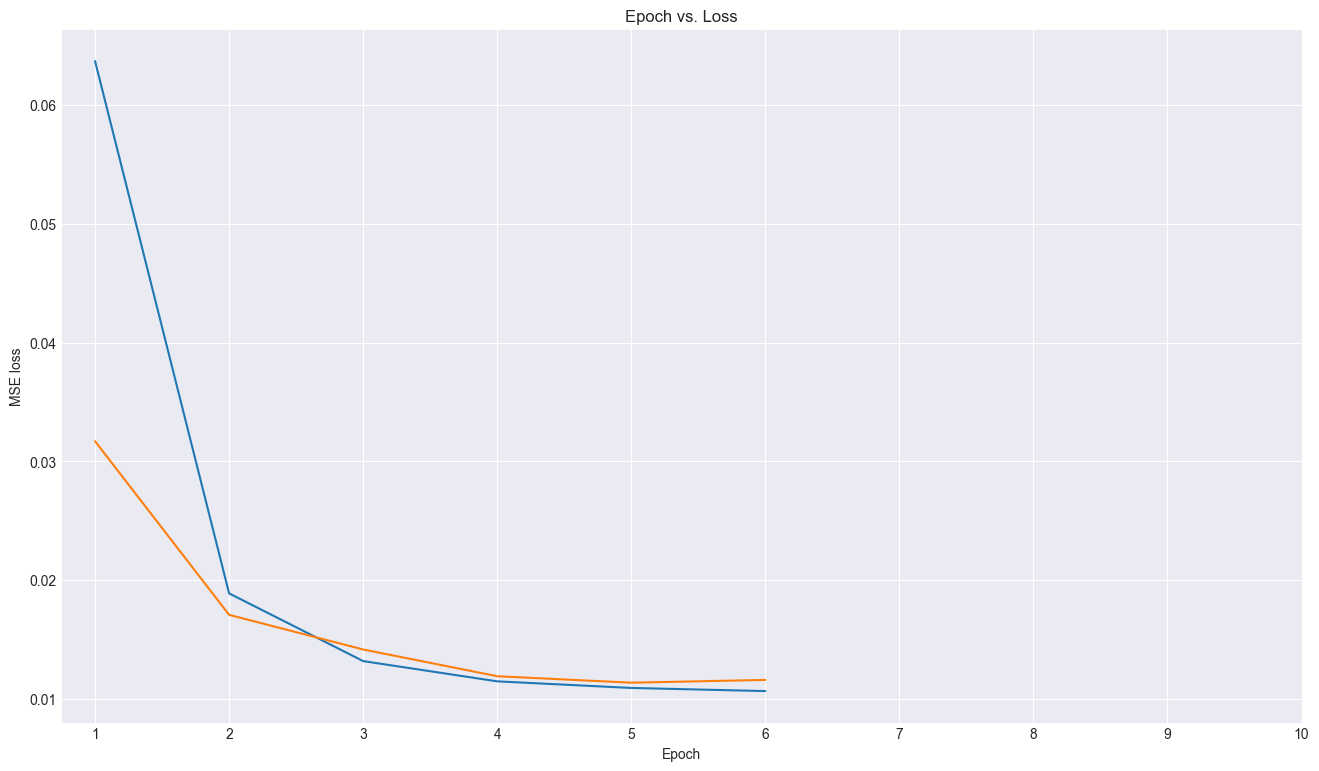

In [ ]:
plt.style.use('seaborn-v0_8-dark')

plt.figure(figsize=(16,9))

plt.plot(np.arange(1, len(all_losses) + 1), all_losses, label="Train")
plt.plot(np.arange(1, len(all_val_losses) + 1), all_val_losses, label="Validation")

plt.xlabel("Epoch")
plt.xticks(np.arange(1, num_epochs + 1))

plt.ylabel("MSE loss")

plt.title(f"Epoch vs. Loss")

plt.grid()

plt.show()


<Figure size 1600x1200 with 0 Axes>

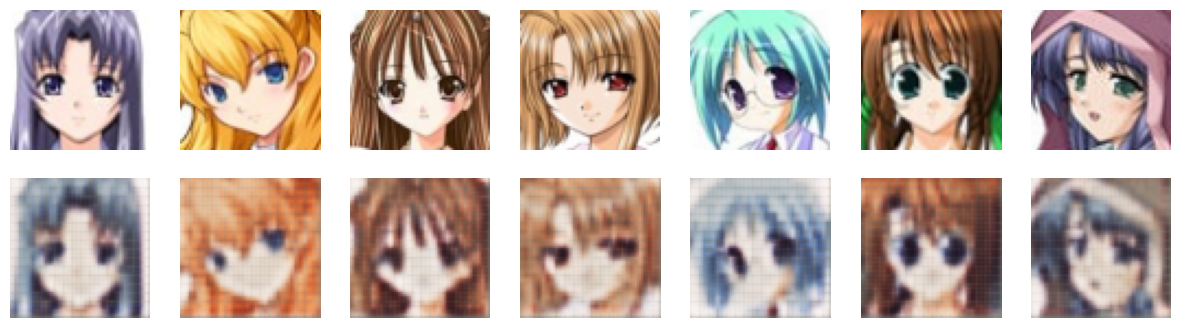

In [77]:
autoencoder.eval()

original = None

reconstruction = None

with torch.no_grad():
    for data in test_loader:
        data = data.to(device)
        original = data

        reconstruction = autoencoder(data)

        break

plt.figure(dpi=250)

fig, ax = plt.subplots(2, 7, figsize=(15, 4))

for i in range(7):
    ax[0, i].imshow(original[i].cpu().numpy().transpose((1, 2, 0)))
    ax[0, i].axis('OFF')

    ax[1, i].imshow(reconstruction[i].cpu().numpy().transpose((1, 2, 0)))
    ax[1, i].axis('OFF')

plt.show()


### Question 3

### In the previous assignment, you worked on designing an LSTM based model for time-series forecasting using PyTorch. In this question, you are required to address the same problem using a transformer-based model. Given a series of data points, the model should be able to predict the next data point. You should use the Daily Climate Time Series dataset for this task. We will only use the "meantemp" column, where the aim is to use the temperatures from the previous days to predict the next temperature value. You are free to choose the architecture and the hyperparameters such that the performance is optimized. The aim is to use the last 10 temperature values to predict the next value. Refer to the third assignments for suggestions on how to preprocess the dataset.

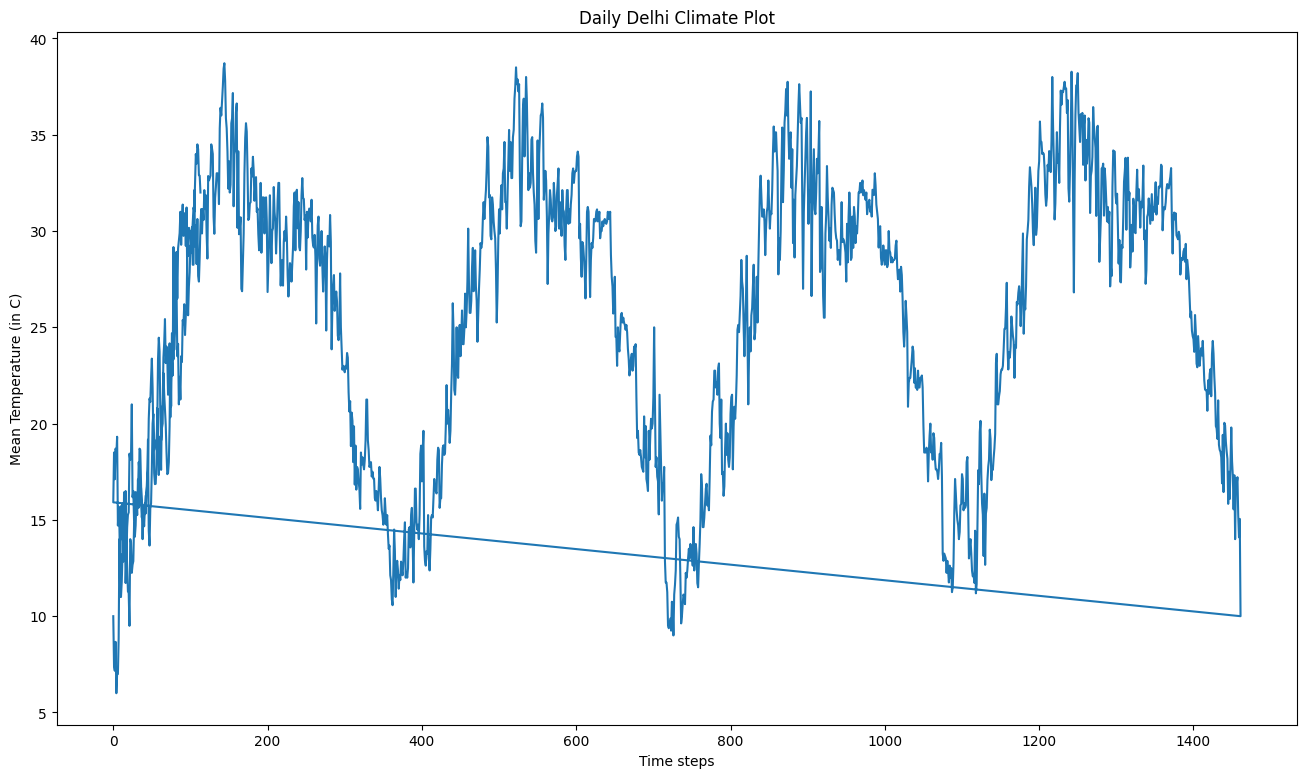

C:\Users\Trim\AppData\Local\Temp\ipykernel_17664\3533780362.py:17: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)
  return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)


In [5]:
climate_train_series = pandas.read_csv("DailyDelhiClimateTrain.csv").meantemp
climate_test_series = pandas.read_csv("DailyDelhiClimateTest.csv").meantemp
climate_full_series = pandas.concat([climate_train_series, climate_test_series], axis=0)
plt.figure(figsize=(16,9))
plt.plot(climate_full_series)
plt.xlabel("Time steps")
plt.ylabel("Mean Temperature (in C)")
plt.title("Daily Delhi Climate Plot")
plt.show()

look_back_window = 10

'''
https://stackoverflow.com/questions/61565156/why-pandas-core-series-series-sometimes-cannot-convert-to-torch-tensor-in-python
Had to convert series into numpy first due to pytorch expecting 0 index to exist per slice 
'''
train_data, train_target = create_dataset(climate_full_series.to_numpy(), look_back_window)



In [6]:
scaler = MinMaxScaler()
train_data = torch.tensor(scaler.fit_transform(train_data, train_target), dtype=torch.float32)


In [ ]:
device = "cuda:0"

batch_size = 8

num_epochs = 10

num_minibatches = math.ceil(len(train_data) / batch_size)

stock_model = DelhiClimateModel(look_back_window, 80)
stock_model.to(device)

optimizer = torch.optim.Adam(stock_model.parameters())

loss_fn = torch.nn.MSELoss()

training_losses = []

for epoch in range(num_epochs):
    total_loss = 0.0

    for i in range(0, train_data.shape[0], batch_size):
        X = train_data[i:i+batch_size].to(device)
        X = X.reshape((X.shape[0], X.shape[1], 1))

        y = train_target[i:i+batch_size].to(device)
        y = y.reshape((X.shape[0], X.shape[1], 1))

        optimizer.zero_grad()

        output = stock_model(X, y)
        loss = loss_fn(output, y)
        loss.backward()

        optimizer.step()

        total_loss += loss.item()

    training_losses.append(total_loss / num_minibatches)

    print(f"Epoch {epoch + 1}: loss (MSE) = {training_losses[-1]:.4f}")


Epoch 1: loss (MSE) = 375.0560
Epoch 2: loss (MSE) = 111.6776
Epoch 3: loss (MSE) = 61.7484
Epoch 4: loss (MSE) = 57.1709
Epoch 5: loss (MSE) = 56.9053
Epoch 6: loss (MSE) = 57.0726
Epoch 7: loss (MSE) = 57.0037
Epoch 8: loss (MSE) = 57.2757
Epoch 9: loss (MSE) = 57.2009
Epoch 10: loss (MSE) = 57.2128


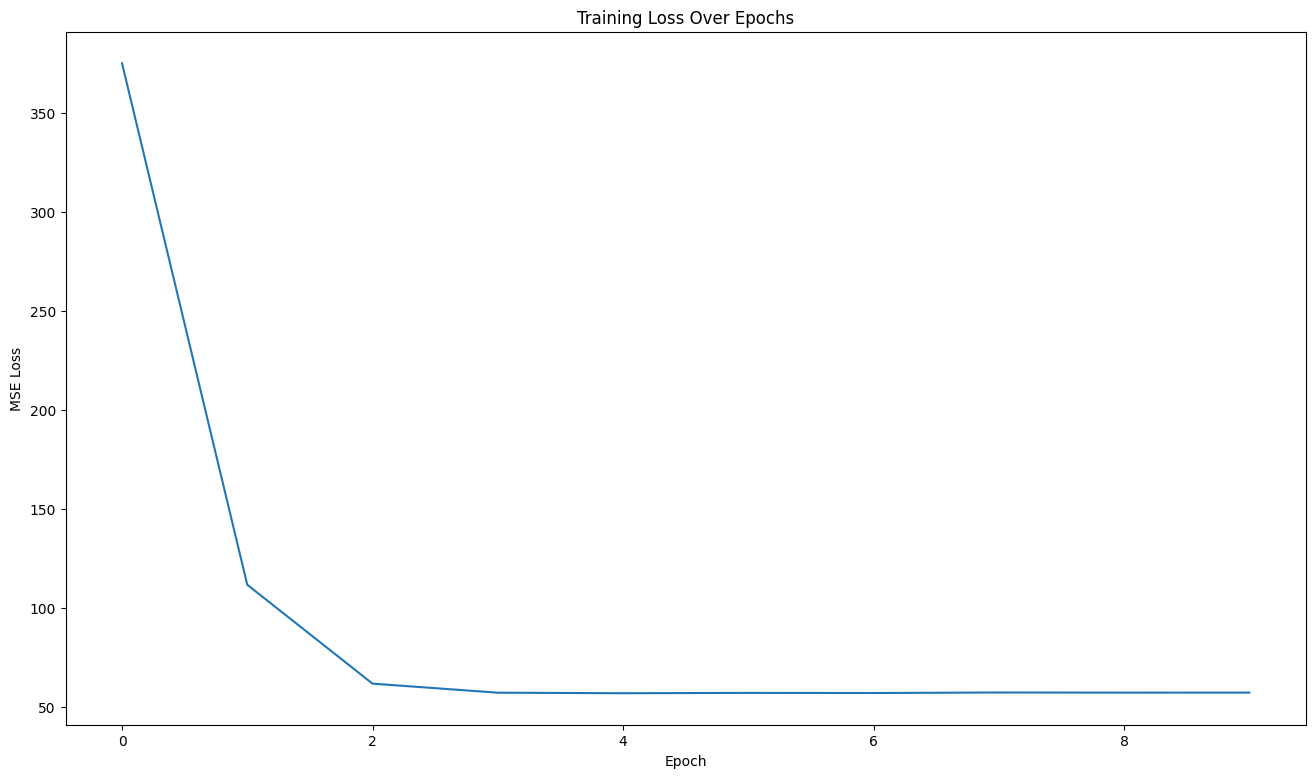

In [45]:
plt.figure(figsize=(16,9))
plt.plot(np.arange(0, len(training_losses)), training_losses)
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Training Loss Over Epochs")
plt.show()


In [46]:
all_outputs = None

with torch.no_grad():
    for i in range(0, train_data.shape[0], batch_size):
        X = train_data[i:i+batch_size].to(device)
        X = X.reshape((X.shape[0], X.shape[1], 1))

        y = train_target[i:i+batch_size].to(device)
        y = y.reshape((X.shape[0], X.shape[1], 1))

        output = stock_model(X, y)

        if all_outputs == None:
            all_outputs = output
        else:
            all_outputs = torch.vstack((all_outputs, output))


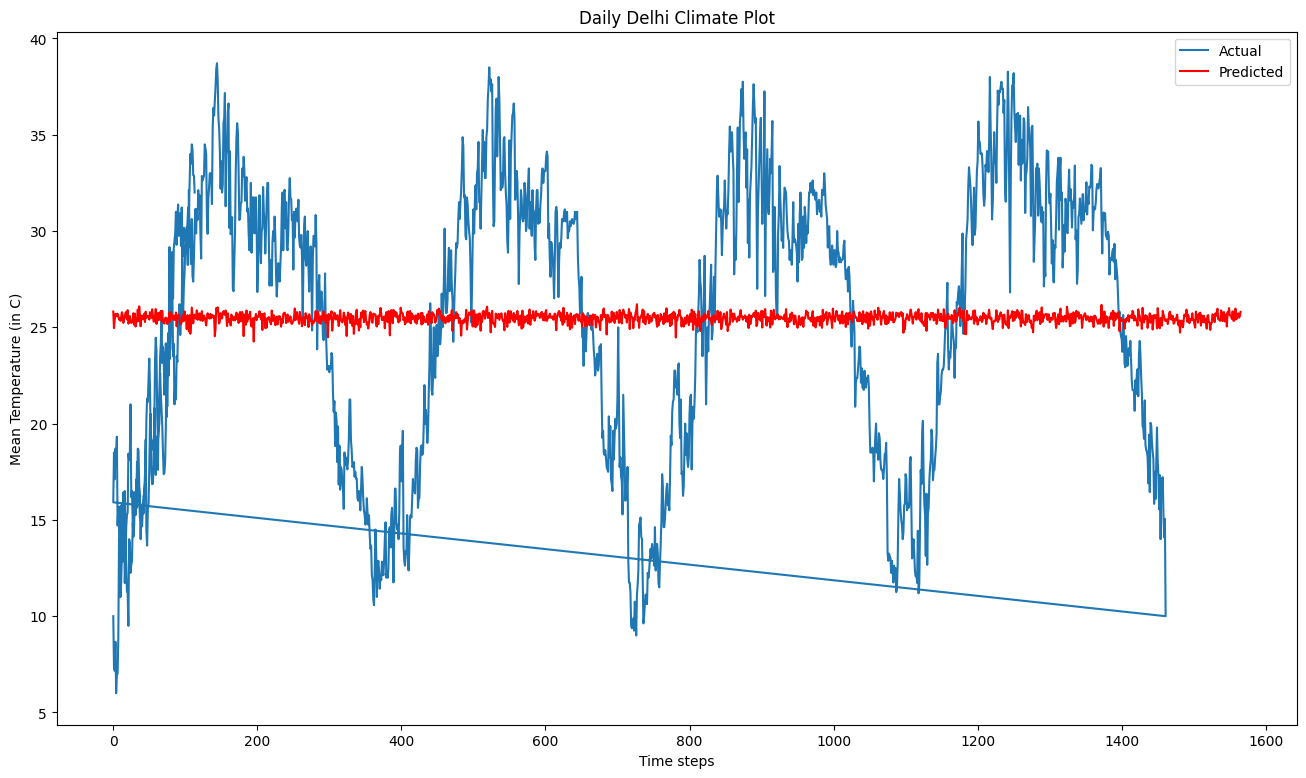

In [47]:
plt.figure(figsize=(16,9))
plt.plot(climate_full_series, label="Actual")
plt.plot(all_outputs[:, -1, 0].cpu(), c='r', label="Predicted")
plt.xlabel("Time steps")
plt.ylabel("Mean Temperature (in C)")
plt.title("Daily Delhi Climate Plot")
plt.legend()
plt.show()
